# Squared Exponential kernel Gaussian process - PriorCVAE


This is a demo notebook to showcase the usage of PriorVAE model on a Gaussian process dataset which is generated using a Squared-Exponential kernel.

In [1]:
import sys
import time
import random as rnd
import time

import numpy as np 
import matplotlib.pyplot as plt 

# Numpyro
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)

#JAX
import jax
import flax
from jax.tree_util import tree_map
from flax.training import train_state  # Useful dataclass to keep train state
import optax
from jax import random
import jax.numpy as jnp

# PyTorch
import torch
import torch.utils.data as data

# print versions
print('Pytorch version: ',   torch.__version__)
print('Numpyro version: ', numpyro.__version__)
print('JAX version:     ',     jax.__version__)
print('Flax version:    ',    flax.__version__)
print('Optax version:   ',   optax.__version__)
from platform import python_version
print('Pythorch version:',python_version())

sys.path.append("..")  # TODO: remove this later, it should be from the installed package.

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.losses import kl_divergence, scaled_sum_squared_loss
from priorCVAE.utility import create_data_loaders
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import GPDataset

import jax.config as config
config.update("jax_enable_x64", True)

Pytorch version:  2.0.1
Numpyro version:  0.12.1
JAX version:      0.4.13
Flax version:     0.6.11
Optax version:    0.1.5
Pythorch version: 3.10.0


### Setup arguments

In [2]:
args = {"seed": 0,
        "conditional": True,
        
        # data
        "num_data": 4000,
        
        # architecture
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 100,
        "num_epochs": 200,
        "vae_var": 1, 

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data


In [3]:
train_set = GPDataset(n_data=args["input_dim"], n_samples=args["num_data"])  
val_set   = GPDataset(n_data=args["input_dim"], n_samples=args["num_data"])  
test_set  = GPDataset(n_data=args["input_dim"], n_samples=args["num_data"])  

train_loader, val_loader, test_loader = create_data_loaders(train_set, val_set, test_set,
                                                            train=[True, False, False],
                                                            batch_size=args["batch_size"])

# these lines are VERY slow and produce MANY warnings - consider removing them
train_loader_iter = iter(train_loader)
val_loader_iter   = iter(val_loader)
test_loader_iter  = iter(test_loader)

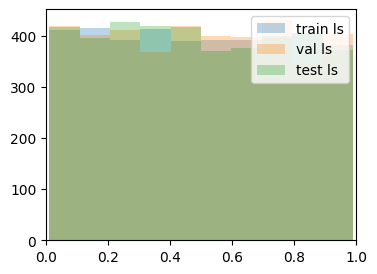

In [4]:
# check: what lengthscales are we generating? 

ls_train_set = train_set.ls
ls_val_set   = val_set.ls
ls_test_set  = test_set.ls

plt.figure(figsize=(4,3))
plt.hist(ls_train_set[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_val_set[:, 0],   alpha = 0.3, label = 'val ls') 
plt.hist(ls_test_set[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()


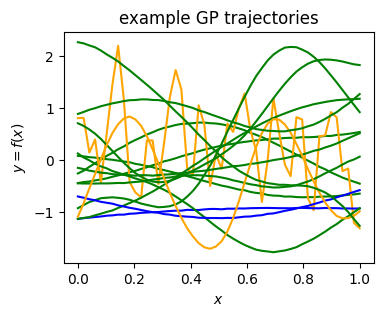

In [5]:
# check: what trajectories are we generating?

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if train_set.ls[i] <= 0.2:
        col = 'orange'
    elif train_set.ls[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(train_set.x[i], train_set.y[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('example GP trajectories')

plt.show()

### VAE Model

In [6]:
conditional = args["conditional"]
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_data    = args["num_data"] 
num_samples = args["num_samples"]
num_epochs  = args["num_epochs"]
vae_var     = args["vae_var"]

### Training loop

In [7]:
@jax.jit
def train_step(state, batch, z_rng):
    def loss_fn(params, z_rng):
        _, y, ls = batch 
        y_hat, z_mu, z_logvar = model.apply({'params': params}, y, z_rng, c=ls) 
        rcl_loss = scaled_sum_squared_loss(y_hat, y, vae_var)
        kld_loss = kl_divergence(z_mu, z_logvar)
        loss = rcl_loss + kld_loss
        return loss
    
    grads = jax.grad(loss_fn)(state.params, z_rng)
    return state.apply_gradients(grads=grads), loss_fn(state.params, z_rng)

In [8]:
@jax.jit
def eval(state, batch, z_rng):
    def loss_fn(params, z_rng):
        _, y, ls = batch         
        y_hat, z_mu, z_logvar = model.apply({'params': params}, y, z_rng, c=ls) 
        rcl_loss = scaled_sum_squared_loss(y_hat, y, vae_var)
        kld_loss = kl_divergence(z_mu, z_logvar)
        loss = rcl_loss + kld_loss
        return loss
    
    return loss_fn(state.params, z_rng)

In [9]:
# define models
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

# initialise parameters
key = jax.random.PRNGKey(0) 
rng, z_key, eval_key = random.split(key, 3)

batch_init = next(val_loader_iter) # batch[0] - x, batch[1] - y, batch[2] - c
_, y, ls = batch_init

params = model.init(rng, y, key, ls)['params']

# optimizer
optimizer = optax.adam(learning_rate=0.001)

# store training state
state = train_state.TrainState.create(apply_fn=model, params=params, tx=optimizer)

_loss_train = []
_loss_test = []

t_start = time.time()

for epoch in range(num_epochs):
    # Training phase
    for _, batch_train in enumerate(train_loader):
        z_key, key = random.split(z_key)
        state, loss_train = train_step(state, batch_train, key)
        _loss_train.append(loss_train)

    # Test phase
    for _, batch_test in enumerate(test_loader):

        eval_key, key = random.split(eval_key)
        loss_test = eval(state, batch_test, key)
        _loss_test.append(loss_test)

    if epoch % 10 == 0:  
        print(f'[{epoch + 1:5d}] training loss: {loss_train:.3f}, test loss: {loss_test:.3f}')

t_elapsed = time.time() - t_start

print(f'Training of {num_epochs} epochs took {round(t_elapsed)} seconds')

assert len(_loss_train) == num_epochs * num_data // batch_size


[    1] training loss: 3058.180, test loss: 2352.827
[   11] training loss: 1104.061, test loss: 972.780
[   21] training loss: 869.271, test loss: 728.888
[   31] training loss: 779.474, test loss: 665.766
[   41] training loss: 781.785, test loss: 603.657
[   51] training loss: 694.705, test loss: 602.579
[   61] training loss: 712.824, test loss: 596.448
[   71] training loss: 691.369, test loss: 595.097
[   81] training loss: 672.556, test loss: 575.326
[   91] training loss: 681.285, test loss: 582.632
[  101] training loss: 664.704, test loss: 584.112
[  111] training loss: 689.187, test loss: 578.087
[  121] training loss: 580.634, test loss: 550.521
[  131] training loss: 603.936, test loss: 568.690
[  141] training loss: 566.623, test loss: 560.106
[  151] training loss: 812.740, test loss: 555.831
[  161] training loss: 736.147, test loss: 562.665
[  171] training loss: 671.862, test loss: 543.215
[  181] training loss: 671.160, test loss: 572.170
[  191] training loss: 676.3

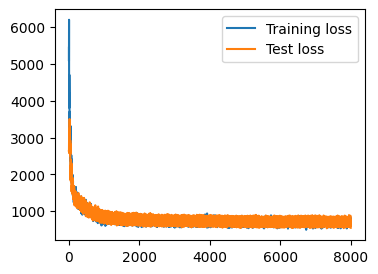

In [10]:
plt.figure(figsize=(4,3))
plt.plot(range(len(_loss_train)), _loss_train, label = 'Training loss')
plt.plot(range(len(_loss_test)), _loss_test, label = 'Test loss')
plt.legend()

#### What have we learnt?

(100, 30)
(100, 50)


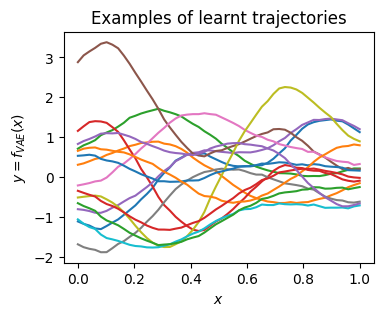

In [11]:
# Get trained decoder params
decoder_params = state.params['decoder']

rng, z_rng, init_rng = random.split(key, 3)

# latents as input
z = random.normal(z_rng, (batch_size, latent_dim))
print(z.shape)

# create decoder
decoder = MLPDecoder(hidden_dim, out_dim)

# apply decoder with trained parameters on the data
c = .1 * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             
print(out.shape)

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(train_set.x[0], out[i, :])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

#### Visual diagnostics

### Inference with MCMC

#### Generate data

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

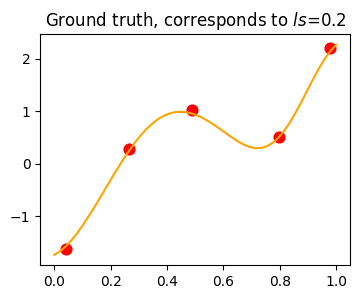

In [12]:
x = train_set[0][0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=args["true_ls"], variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

In [13]:
# add data to args
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

#### Nupmyro model

In [14]:
c = .1 * jnp.ones((1, )) if conditional else None

mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params, c=c)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -1.10      0.29     -1.11     -1.59     -0.64  19327.05      1.00
      f[1]     -1.14      0.30     -1.14     -1.64     -0.64  19271.02      1.00
      f[2]     -1.18      0.31     -1.19     -1.71     -0.68  19231.10      1.00
      f[3]     -1.24      0.33     -1.25     -1.82     -0.74  19214.56      1.00
      f[4]     -1.21      0.32     -1.22     -1.75     -0.68  19189.51      1.00
      f[5]     -1.13      0.31     -1.14     -1.67     -0.64  19320.09      1.00
      f[6]     -1.02      0.30     -1.02     -1.52     -0.54  19476.21      1.00
      f[7]     -0.87      0.29     -0.87     -1.34     -0.40  19834.87      1.00
      f[8]     -0.68      0.26     -0.68     -1.13     -0.26  20545.78      1.00
      f[9]     -0.47      0.25     -0.46     -0.90     -0.07  21428.01      1.00
     f[10]     -0.31      0.25     -0.30     -0.72      0.11  22228.38      1.00
     f[11]     -0.10      0

Text(0.5, 1.0, 'PriorVAE inference')

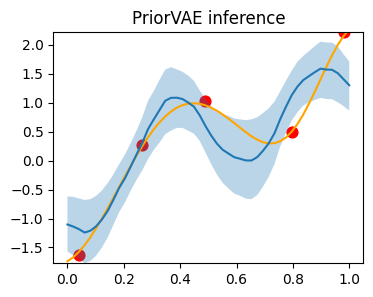

In [15]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)

c = .1 * jnp.ones((1, )) if conditional else None
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params, c)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorVAE inference')